#experimental

In [ ]:
#pre-processing again to only get the non-clausal dependents
import os
import pandas as pd
from collections import Counter
from conllu import parse_incr
import gc # Import garbage collection

# Define a dictionary for standardizing dependency labels
standardized_deprels = {
    "nm": "nmod",
    "nmod:poss": "nmod",
    "nmod:det": "nmod",
    "adjmod": "amod",
    "al:relcl": "acl:relcl",
    "acl:recl": "acl:relcl"
}

stopwords_deprels = ['punct', 'reparandum']

def standardize_deprel(deprel):
    return standardized_deprels.get(deprel, deprel)

def convert_tuple_id_to_float(id_tuple):
    if isinstance(id_tuple, tuple) and len(id_tuple) == 3:
        integer_part = id_tuple[0]
        decimal_part = id_tuple[2]
        id_num = f"{integer_part}.{decimal_part}"
        return float(id_num)
    try:
        return float(id_tuple)
    except (ValueError, TypeError):
         return None

class Token:
    def __init__(self, id_, form, lemma, upos, xpos, feats, head, deprel, deps, misc):
        self.id = id_
        self.form = form
        self.lemma = lemma
        self.upos = upos
        self.xpos = xpos
        self.feats = feats if feats is not None else {}
        self.head = head
        self.deprel = deprel
        self.deps = deps
        self.misc = misc
        self._resolved_head = head
        self._resolved_deprel = deprel

    def resolve_conj(self, token_list):
        """Recursively resolve 'conj' deprel by traversing to the head's deprel if necessary."""
        if self._resolved_head is not None and self._resolved_deprel != 'conj':
             self.head = self._resolved_head
             self.deprel = self._resolved_deprel
             return

        current_token = self
        path = [convert_tuple_id_to_float(current_token.id)]

        while convert_tuple_id_to_float(current_token.deprel) == 'conj' and convert_tuple_id_to_float(current_token.head) != 0:
            head_token = next((t for t in token_list if convert_tuple_id_to_float(t.id) == convert_tuple_id_to_float(current_token.head)), None)

            if head_token is None:
                break

            head_token_float_id = convert_tuple_id_to_float(head_token.id)
            if head_token_float_id is None or head_token_float_id in path:
                 if head_token_float_id is not None:
                     print(f"Warning: Cycle or invalid head detected involving token ID {self.id} during conj resolution.")
                 break

            path.append(head_token_float_id)
            current_token = head_token

        self._resolved_head = convert_tuple_id_to_float(current_token.head)
        self._resolved_deprel = current_token.deprel
        self.head = self._resolved_head
        self.deprel = self._resolved_deprel


class Sentence:
    def __init__(self, sentence_id, tokens, metadata=None):
        self.sentence_id = sentence_id
        self.tokens = tokens
        self.metadata = metadata if metadata else {}

    def get_tokens(self):
        return self.tokens

head_lemma_counts = Counter()
dependent_lemma_counts = Counter()

def update_lemma_counts(tokens):
    for token in tokens:
        if token.upos in {'NOUN', 'PROPN', 'ADJ'}:
            head_lemma_counts[token.lemma] += 1
        else:
            dependent_lemma_counts[token.lemma] += 1

def get_np_depth(token, token_list, depth=0, max_depth=10, visited=None):
    if visited is None:
        visited = set()

    token_float_id = convert_tuple_id_to_float(token.id)
    if token_float_id is None or token_float_id in visited:
        return depth

    visited.add(token_float_id)

    dependents = [t for t in token_list if convert_tuple_id_to_float(t.head) == token_float_id]

    if not dependents or depth >= max_depth:
        return depth

    dependent_depths = [get_np_depth(dep, token_list, depth + 1, max_depth, visited) for dep in dependents if convert_tuple_id_to_float(dep.id) is not None]

    if not dependent_depths:
         return depth
    else:
         return max(dependent_depths + [depth])


def get_plurality(token_feats):
    number = token_feats.get("Number", "Sing")
    return number


def process_nominal_heads(token_list, source_file_name):
    nominal_data = []
    potential_ezafe_markers = {'ī'}

    valid_dependent_deprels = ['nmod', 'amod', 'flat', 'cc', 'det', 'clf', 'nummod', 'advmod', 'appos', 'nmod:poss', 'nmod:det']

    potential_nominal_heads = [t for t in token_list if t.upos in {'NOUN', 'PROPN', 'PRON'} and convert_tuple_id_to_float(t.head) != 0]

    for nominal_head in potential_nominal_heads:
        nominal_head_id_float = convert_tuple_id_to_float(nominal_head.id)
        if nominal_head_id_float is None: continue

        all_head_dependents = [t for t in token_list if convert_tuple_id_to_float(t.head) == nominal_head_id_float]

        dependents_for_pairs = [t for t in all_head_dependents if t.deprel in valid_dependent_deprels and t.lemma not in ['ī', 'ud']]

        if not dependents_for_pairs:
            continue

        num_nouns_before = sum(1 for t in token_list if t.upos in {'NOUN', 'PROPN'} and convert_tuple_id_to_float(t.id) is not None and convert_tuple_id_to_float(t.id) < nominal_head_id_float)
        num_adjs_before = sum(1 for t in token_list if t.upos == 'ADJ' and convert_tuple_id_to_float(t.id) is not None and convert_tuple_id_to_float(t.id) < nominal_head_id_float)
        num_adjs_after = sum(1 for t in token_list if t.upos == 'ADJ' and convert_tuple_id_to_float(t.id) is not None and convert_tuple_id_to_float(t.id) > nominal_head_id_float)

        np_depth = get_np_depth(nominal_head, token_list)

        head_number = get_plurality(nominal_head.feats)

        num_dependents_head = len(all_head_dependents)

        np_deprel_pattern = " ".join(t.deprel for t in all_head_dependents)


        for dependent in dependents_for_pairs:
            dependent_id_float = convert_tuple_id_to_float(dependent.id)
            if dependent_id_float is None: continue

            distance = abs(dependent_id_float - nominal_head_id_float)

            position = 1 if nominal_head_id_float < dependent_id_float else 2

            has_ezafe = any(t.lemma in potential_ezafe_markers and convert_tuple_id_to_float(t.head) == dependent_id_float for t in token_list)

            head_freq = head_lemma_counts.get(nominal_head.lemma, 0)
            mod_freq = dependent_lemma_counts.get(dependent.lemma, 0)

            relative_position = nominal_head_id_float / (len(token_list) if len(token_list)>0 else 1e-5)

            modifier_to_head_ratio = mod_freq / (head_freq + 1e-5)


            nominal_data.append({
                'nominal_head_id': nominal_head_id_float,
                'nominal_head_form': nominal_head.form,
                'nominal_head_upos': nominal_head.upos,
                'nominal_head_deprel': nominal_head.deprel,
                'head_number': head_number,
                'head_frequency': head_freq,
                'dependent_frequency': mod_freq,
                'modifier_to_head_ratio': modifier_to_head_ratio,
                'dependent_id': dependent_id_float,
                'dependent_form': dependent.form,
                'dependent_upos': dependent.upos,
                'dependent_deprel': dependent.deprel,
                'distance': distance,
                'position': position,
                'num_nouns_before': num_nouns_before,
                'num_adjs_before': num_adjs_before,
                'num_adjs_after': num_adjs_after,
                'np_depth': np_depth,
                'num_dependents_head': num_dependents_head,
                'num_dependents_dependent': len([t for t in token_list if convert_tuple_id_to_float(t.head) == dependent_id_float]),
                'ezafe_label': int(has_ezafe),
                'relative_position_in_sent': relative_position,
                'np_deprel_pattern': np_deprel_pattern,
                'source_file': source_file_name
            })

    return nominal_data



def process_conllu_file(file_path):
    file_name = os.path.basename(file_path)
    nominal_rows = []
    token_rows_per_file = []

    try:
        with open(file_path, 'r', encoding='utf-8') as data_file:
            for sentence in parse_incr(data_file):
                tokens_list_orig = []
                sentence_idx = sentence.metadata.get("sent_id", f"sent{len(sentence)}")

                sentence_text = sentence.metadata.get("text", "")
                newpart = sentence.metadata.get("newpart", "")
                translation = sentence.metadata.get("translation", "")

                for token_data in sentence:
                     token_id_float = convert_tuple_id_to_float(token_data['id'])
                     if token_id_float is not None:
                        standardized_deprel = standardize_deprel(token_data["deprel"])
                        head_id_float = convert_tuple_id_to_float(token_data["head"])

                        token = Token(
                            id_=token_id_float,
                            form=token_data["form"],
                            lemma=token_data["lemma"],
                            upos=token_data["upos"],
                            xpos=token_data["xpos"],
                            feats=token_data.get("feats", {}),
                            head=head_id_float,
                            deprel=standardized_deprel,
                            deps=token_data["deps"],
                            misc=token_data.get("misc", {}),
                        )
                        tokens_list_orig.append(token)

                        token_rows_per_file.append({
                            "id": token.id,
                            "form": token.form,
                            "lemma": token.lemma,
                            "upos": token.upos,
                            "xpos": token.xpos,
                            "feats": token.feats,
                            "head": token.head,
                            "deprel": token.deprel,
                            "misc": token.misc,
                            "sent_id": sentence_idx,
                            "text": sentence_text,
                            "newpart": newpart,
                            "translation": translation,
                            "source_file": file_name,
                        })

                for token in tokens_list_orig:
                     token.resolve_conj(tokens_list_orig)

                filtered_tokens_for_np_processing = [t for t in tokens_list_orig if t.deprel not in stopwords_deprels and convert_tuple_id_to_float(t.head) is not None]

                nominal_rows.extend(process_nominal_heads(filtered_tokens_for_np_processing, file_name))

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

    return nominal_rows, token_rows_per_file


folder_path = r'C:\\Users\\rahaa\\Dropbox\\MPCD\\conllus_with_erros' # Use raw string for path

all_nominal_rows = []
all_token_rows = []
head_lemma_counts = Counter()
dependent_lemma_counts = Counter()

print("--- First pass: Collecting all tokens and lemma counts ---")
if os.path.exists(folder_path):
    conllu_files = [f for f in os.listdir(folder_path) if f.endswith(".conllu")]
    for filename in conllu_files:
        file_path = os.path.join(folder_path, filename)
        print(f"Collecting tokens and counts from {filename}...")
        try:
            with open(file_path, 'r', encoding='utf-8') as data_file:
                 for sentence in parse_incr(data_file):
                      sentence_tokens = []
                      for token_data in sentence:
                           token_id_float = convert_tuple_id_to_float(token_data['id'])
                           if token_id_float is not None:
                                standardized_deprel = standardize_deprel(token_data["deprel"])
                                if standardized_deprel not in stopwords_deprels:
                                     head_id_float = convert_tuple_id_to_float(token_data["head"])
                                     token = Token(token_id_float, token_data["form"], token_data["lemma"], token_data["upos"], token_data["xpos"], token_data.get("feats", {}), head_id_float, standardized_deprel, token_data["deps"], token_data.get("misc", {}))
                                     sentence_tokens.append(token)

                      update_lemma_counts(sentence_tokens)

        except Exception as e:
             print(f"Error collecting tokens from {file_path}: {e}")
else:
    print(f"Directory {folder_path} does not exist.")
    conllu_files = []


print("\n--- Second pass: Extracting nominal phrase features ---")
if os.path.exists(folder_path) and conllu_files:
    for filename in conllu_files:
        file_path = os.path.join(folder_path, filename)
        print(f"Processing {filename} for features...")
        nominal_rows_file, token_rows_file = process_conllu_file(file_path)
        all_nominal_rows.extend(nominal_rows_file)
        all_token_rows.extend(token_rows_file)

else:
     if not os.path.exists(folder_path):
          print(f"Directory {folder_path} does not exist.")
     elif not conllu_files:
          print("No .conllu files found in the directory.")


if all_nominal_rows:
    nominals_df = pd.DataFrame(all_nominal_rows)
    nominals_df.to_csv("nonclausal-np_features.csv", index=False)
    print("\nNominal phrase features saved to nonclausal-np_features.csv")

    print(nominals_df.dtypes)
else:
    print("\nNo nominal data to save.")

if all_token_rows:
    token_df = pd.DataFrame(all_token_rows)
    token_df.to_csv("all_tokens.csv", index=False)
    print("All token data saved to all_tokens.csv")
else:
    print("No token data to save.")

--- First pass: Collecting all tokens and lemma counts ---

--- Second pass: Extracting nominal phrase features ---
Processing Col_RFS_TD2.conllu for features...
Processing DD-K35.conllu for features...
Processing Dk5_B.conllu for features...
Processing Dk7-B.conllu for features...
Processing DMX-L19.conllu for features...
Processing GBd_TD1.conllu for features...
Processing NM_K35.conllu for features...
Processing NM_TD4a.conllu for features...
Processing RAF-TD2.conllu for features...
Processing RFS-TD2.conllu for features...
Processing ZWY-K20.conllu for features...
Processing ZWY-K43a.conllu for features...

Nominal phrase features saved to nonclausal-np_features.csv
nominal_head_id              float64
nominal_head_form             object
nominal_head_upos             object
nominal_head_deprel           object
head_number                   object
head_frequency                 int64
dependent_frequency            int64
modifier_to_head_ratio       float64
dependent_id            

In [28]:
# src/rf_preprocess_data.py
# Author: Raha Musavi
# Matrikelnummer: 08022255354
# Thesis: Modeling the Presence and the Classification of Ezafe in Middle Persian Nominal Phrases 
# Date: 01 May 2025

import os
import pandas as pd
from collections import Counter
from conllu import parse_incr
import gc

# Standard dependency label mapping
standardized_deprels = {
    "nm": "nmod",
    "nmod:poss": "nmod",
    "nmod:det": "nmod",
    "adjmod": "amod",
    "al:relcl": "acl:relcl",
    "acl:recl": "acl:relcl"
}

# Dependency relations to filter out from NP analysis
stopwords_deprels = ['punct', 'reparandum']

# Function to standardize dependency relation
def standardize_deprel(deprel):
    return standardized_deprels.get(deprel, deprel)

# Function to convert token ID to float, skipping multi-word token ranges and strings
def convert_id_to_float(id_val):
    if isinstance(id_val, int):
        return float(id_val)
    # Skip tuple IDs (likely MWT ranges) and string IDs (likely MWT)
    elif isinstance(id_val, (tuple, str)):
         return None
    else:
        try:
            return float(id_val)
        except (ValueError, TypeError):
             return None


# Token class with conj resolution method
class Token:
    def __init__(self, data):
        self.id = convert_id_to_float(data['id'])
        self.form = data.get('form')
        self.lemma = data.get('lemma')
        self.upos = data.get('upos')
        self.xpos = data.get('xpos')
        self.feats = data.get('feats', {}) if data.get('feats') is not None else {}
        self.head = convert_id_to_float(data.get('head'))
        self.deprel = standardize_deprel(data.get('deprel'))

        # Attributes to store resolved head/deprel after conj resolution
        self._resolved_head = self.head
        self._resolved_deprel = self.deprel

    # User-specified resolve_conj method
    def resolve_conj(self, token_map):
        """Recursively resolve 'conj' deprel by traversing to the head's deprel if necessary."""
        # If already resolved and not 'conj', use the resolved value
        if self._resolved_head is not None and self._resolved_deprel != 'conj':
             self.head = self._resolved_head
             self.deprel = self._resolved_deprel
             return

        current_token = self
        path = [current_token.id] # Track path using float IDs to detect cycles

        # Continue traversing up the tree as long as the current token has a 'conj' relation
        # and is not the root (head != 0 and head is not None)
        # Use the already resolved deprel/head within the loop for traversal
        # NOTE: This assumes resolve_conj might be called iteratively.
        original_head = convert_id_to_float(self._resolved_head) # Stored initial head
        original_deprel = self._resolved_deprel # Stored initial deprel

        temp_head = original_head
        temp_deprel = original_deprel

        while temp_deprel == 'conj' and temp_head is not None and temp_head != 0:
             head_token = token_map.get(temp_head) # Find head token by ID

             if head_token is None:
                 # No head found for the current token, break the loop
                 #highly unlikely but handling gracefully
                 break

             if head_token.id in path:
                  # Cycle detected, break the loop
                  print(f"Warning: Cycle detected involving token ID {self.id} during conj resolution.")
                  break

             path.append(head_token.id)
             # Move up to the head's original head and deprel for the next step in traversal
             temp_head = convert_id_to_float(head_token._resolved_head) # Access head's original head
             temp_deprel = head_token._resolved_deprel # Access head's original deprel

        # Store the resolved head and deprel (from the token where the loop stopped)
        # The resolved head should be the head of the non-conjunct token
        self._resolved_head = temp_head
        self._resolved_deprel = temp_deprel


# Global lemma counts (populated in the first pass)
head_lemma_counts = Counter()
dependent_lemma_counts = Counter()

# Update lemma counts based on tokens after stopwords filter
def update_lemma_counts(tokens):
    upos_for_head_lemma = {'NOUN', 'PROPN', 'PRON'}
    for token in tokens:
        if token.lemma:
             if token.upos in upos_for_head_lemma:
                 head_lemma_counts[token.lemma] += 1
             else:
                 dependent_lemma_counts[token.lemma] += 1

# Calculate NP depth
def get_np_depth(token, token_map, depth=0, max_depth=20, visited=None):
    if visited is None:
        visited = set()

    if token.id is None or token.id in visited or depth >= max_depth:
        return depth

    visited.add(token.id)

    # Find dependents using the token_map and the token's ID (using resolved head)
    dependents = [t for t in token_map.values() if t.head == token.id]

    if not dependents:
        return depth

    dependent_depths = [get_np_depth(dep, token_map, depth + 1, max_depth, visited) for dep in dependents]

    if not dependent_depths:
         return depth
    else:
         return max(dependent_depths)


# Get plurality information
def get_plurality(token_feats):
    number = token_feats.get("Number", "Sing")
    return number


# Process nominal heads and their dependents for feature extraction
def process_nominal_heads(token_map_filtered_for_np, token_map_resolved, source_file_name, head_lemma_counts, dependent_lemma_counts):
    nominal_data = []
    potential_ezafe_markers = {'ī'}

    # Valid dependency relations for immediate dependents to form pairs with the head
    valid_dependent_deprels_for_pair = ['nmod', 'amod', 'flat', 'cc', 'det', 'clf', 'nummod', 'advmod', 'appos', 'nmod:poss', 'nmod:det']

    # Identify potential nominal heads based on UPOS and resolved head != 0
    potential_nominal_heads = [t for t in token_map_filtered_for_np.values() if t.upos in {'NOUN', 'PROPN', 'ADJ'} and t.head is not None and t.head != 0]

    # Create a list of all tokens *in this sentence* from the resolved map, sorted by original ID for linear features
    all_sentence_tokens_resolved_sorted = sorted([t for t in token_map_resolved.values() if t.id is not None], key=lambda x: x.id)
    sentence_token_count = len(all_sentence_tokens_resolved_sorted)
    if sentence_token_count == 0: return []

    # Create a map of ID to sorted index for quick lookups
    id_to_index = {token.id: i for i, token in enumerate(all_sentence_tokens_resolved_sorted)}


    for nominal_head in potential_nominal_heads:
        nominal_head_id_float = nominal_head.id
        if nominal_head_id_float is None or nominal_head_id_float not in id_to_index: continue

        # Find all dependents of this head (using the resolved head ID) from the resolved map
        all_head_dependents = [t for t in token_map_resolved.values() if t.head == nominal_head_id_float]

        # Filter these dependents based on the valid dependency relations and lemmas 'ī', 'ud' for pair creation
        dependents_for_pairs = [t for t in all_head_dependents if t.deprel in valid_dependent_deprels_for_pair and t.lemma not in ['ī', 'ud']]

        if not dependents_for_pairs:
            continue

        # Calculate counts before/after the head based on linear index
        head_index = id_to_index[nominal_head_id_float]
        num_nouns_before = sum(1 for i in range(head_index) if all_sentence_tokens_resolved_sorted[i].upos in {'NOUN', 'PROPN'})
        num_adjs_before = sum(1 for i in range(head_index) if all_sentence_tokens_resolved_sorted[i].upos == 'ADJ')
        num_nouns_after = sum(1 for i in range(head_index + 1, sentence_token_count) if all_sentence_tokens_resolved_sorted[i].upos in {'NOUN', 'PROPN'})
        num_adjs_after = sum(1 for i in range(head_index + 1, sentence_token_count) if all_sentence_tokens_resolved_sorted[i].upos == 'ADJ')


        # Calculate NP depth of the head's subtree using the resolved token map
        np_depth = get_np_depth(nominal_head, token_map_resolved)


        # Get head plurality
        head_number = get_plurality(nominal_head.feats)

        # num_dependents_head is the count of *all* dependents of the head (from all_head_dependents)
        num_dependents_head = len(all_head_dependents)

        # np_deprel_pattern: Join resolved deprels of *all* dependents of the head
        np_deprel_pattern = " ".join(t.deprel for t in all_head_dependents)


        for dependent in dependents_for_pairs: # Iterate over the filtered list to create pairs
            dependent_id_float = dependent.id
            if dependent_id_float is None or dependent_id_float not in id_to_index: continue

            distance = abs(dependent_id_float - nominal_head_id_float)

            # position: 1 = dependent precedes head, 2 = follows (based on linear index)
            dependent_linear_index = id_to_index[dependent_id_float]
            head_linear_index = id_to_index[nominal_head_id_float]
            position = 1 if dependent_linear_index < head_linear_index else 2

            # Check for ezafe marker 'ī' attached to the dependent (using resolved head)
            has_ezafe = any(t.lemma in potential_ezafe_markers and t.head == dependent_id_float for t in token_map_resolved.values())

            # Get lemma frequencies
            head_freq = head_lemma_counts.get(nominal_head.lemma, 0)
            mod_freq = dependent_lemma_counts.get(dependent.lemma, 0)

            # Calculate relative position of the head in sentence (normalized by sentence token count)
            relative_position = head_linear_index / (sentence_token_count - 1) if sentence_token_count > 1 else 0.0

            # Create modifier-to-head ratio feature
            modifier_to_head_ratio = mod_freq / (head_freq + 1e-5)

            # num_dependents_dependent is the count of dependents of the *current* dependent (using resolved head)
            num_dependents_dependent = len([t for t in token_map_resolved.values() if t.head == dependent_id_float])


            nominal_data.append({
                'nominal_head_id': nominal_head_id_float,
                'nominal_head_form': nominal_head.form,
                'nominal_head_upos': nominal_head.upos,
                'nominal_head_deprel': nominal_head.deprel, # Resolved deprel
                'head_number': head_number,
                'head_frequency': head_freq,
                'dependent_frequency': mod_freq,
                'modifier_to_head_ratio': modifier_to_head_ratio,
                'dependent_id': dependent_id_float,
                'dependent_form': dependent.form,
                'dependent_upos': dependent.upos,
                'dependent_deprel': dependent.deprel, # Resolved deprel
                'distance': distance,
                'position': position,
                'num_nouns_before': num_nouns_before,
                'num_nouns_after': num_nouns_after,
                'num_adjs_before': num_adjs_before,
                'num_adjs_after': num_adjs_after,
                'np_depth': np_depth,
                'num_dependents_head': num_dependents_head,
                'num_dependents_dependent': num_dependents_dependent,
                'ezafe_label': int(has_ezafe),
                'relative_position_in_sent': relative_position,
                'np_deprel_pattern': np_deprel_pattern,
                'source_file': source_file_name
            })

    return nominal_data


def process_conllu_file(file_path, head_lemma_counts, dependent_lemma_counts):
    file_name = os.path.basename(file_path)
    nominal_rows = []
    all_tokens_in_file_raw_data = [] # Store raw token data for this file

    try:
        with open(file_path, 'r', encoding='utf-8') as data_file:
            for sentence_tokens_list in parse_incr(data_file):
                if not sentence_tokens_list: continue

                # --- Sentence Processing ---
                sentence_id = sentence_tokens_list.metadata.get("sent_id", f"sent_{len(all_tokens_in_file_raw_data)}_{len(sentence_tokens_list)}")
                # Extract sentence metadata
                sentence_text = sentence_tokens_list.metadata.get("text", "")
                newpart = sentence_tokens_list.metadata.get("newpart", "")
                translation = sentence_tokens_list.metadata.get("translation", "")


                # Create Token objects (initial state) and map for the current sentence
                sentence_token_objects_orig = []
                token_map_orig = {}
                sentence_raw_data = []

                for token_data in sentence_tokens_list:
                    # Skip non-token lines & multi-word tokens
                    token_id_float = convert_id_to_float(token_data['id'])
                    if token_id_float is not None:
                        token = Token(token_data)
                        sentence_token_objects_orig.append(token)
                        token_map_orig[token.id] = token

                        # Prepare raw token data row for saving
                        sentence_raw_data.append({
                            "id": token.id,
                            "form": token.form,
                            "lemma": token.lemma,
                            "upos": token.upos,
                            "xpos": token.xpos,
                            "feats": token.feats,
                            "head": convert_id_to_float(token_data.get('head')), # Store initial head ID in raw data
                            "deprel": standardize_deprel(token_data.get('deprel')), # Store initial standardized deprel in raw data
                            "misc": token.misc,
                            "sent_id": sentence_id,
                            "text": sentence_text,
                            "newpart": newpart, # Added as per original notebook code
                            "translation": translation, # Added as per original notebook code
                            "source_file": file_name,
                        })

                # --- Resolve Conj Relations ---
                # Resolve conj relations for all tokens in this sentence (modifies token objects)
                for token in sentence_token_objects_orig:
                     token.resolve_conj(token_map_orig)

                # --- Create Resolved Token Map and Filter for NP Analysis ---
                # Create a new map reflecting resolved heads/deprels
                token_map_resolved = {token.id: token for token in sentence_token_objects_orig if token.id is not None}

                # Filter out stopwords/reparandum from the resolved map for NP analysis
                token_map_filtered_for_np = {
                    token_id: token for token_id, token in token_map_resolved.items()
                    if token.deprel not in stopwords_deprels
                }

                # --- Extract Nominal Phrase Features ---
                nominal_rows.extend(process_nominal_heads(token_map_filtered_for_np, token_map_resolved, file_name, head_lemma_counts, dependent_lemma_counts))

                # Add raw token data for this sentence to the file list
                all_tokens_in_file_raw_data.extend(sentence_raw_data)


    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return [], []

    return nominal_rows, all_tokens_in_file_raw_data


# --- Main execution for rf_preprocess_data.py ---
if __name__ == "__main__":
    folder_path = r'C:\Users\rahaa\Dropbox\MPCD\conllus_with_erros' # UPDATE THIS PATH

    os.makedirs('data', exist_ok=True)

    # Initialize global lists and counters
    all_nominal_rows_collected = []
    all_token_rows_collected = []
    # Reset lemma counts (globally initialized)
    head_lemma_counts = Counter()
    dependent_lemma_counts = Counter()


    print("--- Step 1: Initial Preprocessing (rf_preprocess_data.py) ---")

    if os.path.exists(folder_path):
        conllu_files = [f for f in os.listdir(folder_path) if f.endswith(".conllu")]

        # First pass across all files to populate global lemma counts
        print("--- First pass: Collecting all tokens and lemma counts ---")
        relevant_tokens_for_lemma_count_across_files = []
        for filename in conllu_files:
            file_path = os.path.join(folder_path, filename)
            print(f"Collecting tokens and counts from {filename}...")
            try:
                with open(file_path, 'r', encoding='utf-8') as data_file:
                    for sentence_tokens_list in parse_incr(data_file):
                        if not sentence_tokens_list: continue
                        sentence_token_objects_orig = []
                        for token_data in sentence_tokens_list:
                             token_id_float = convert_id_to_float(token_data['id'])
                             if token_id_float is not None:
                                 token = Token(token_data)
                                 # Include tokens with valid IDs and not stopwords for lemma counts
                                 if token.deprel not in stopwords_deprels:
                                     relevant_tokens_for_lemma_count_across_files.append(token)

            except Exception as e:
                 print(f"Error collecting tokens from {file_path}: {e}")

        update_lemma_counts(relevant_tokens_for_lemma_count_across_files)
        del relevant_tokens_for_lemma_count_across_files
        gc.collect()


        # Second pass across all files to process sentences and extract features
        print("\n--- Second pass: Processing files for features ---")
        for filename in conllu_files:
            file_path = os.path.join(folder_path, filename)
            print(f"Processing {filename} for features...")
            nominal_rows_file, all_tokens_in_file_raw_data_current = process_conllu_file(file_path, head_lemma_counts, dependent_lemma_counts)
            all_nominal_rows_collected.extend(nominal_rows_file)
            all_token_rows_collected.extend(all_tokens_in_file_raw_data_current)


    else:
         print(f"Error: Directory {folder_path} does not exist.")
         conllu_files = []

    # Save the collected dataframes after processing all files
    if all_nominal_rows_collected:
        nominals_df = pd.DataFrame(all_nominal_rows_collected)
        nominals_df.to_csv("data/rf_np_inputs.csv", index=False)
        print("\nNominal phrase initial features saved to data/rf_np_inputs.csv")
        print(nominals_df.dtypes)

    else:
        print("\nNo nominal data to save.")

    # Save all token data
    if all_token_rows_collected:
        token_df = pd.DataFrame(all_token_rows_collected)
        token_df.to_csv("data/all_tokens.csv", index=False)
        print("All token data saved to data/all_tokens.csv")
    else:
        print("No token data to save.")

    print("\n--- Initial Preprocessing Complete ---")

--- Step 1: Initial Preprocessing (rf_preprocess_data.py) ---
--- First pass: Collecting all tokens and lemma counts ---

--- Second pass: Processing files for features ---
Processing Col_RFS_TD2.conllu for features...
Error processing file C:\Users\rahaa\Dropbox\MPCD\conllus_with_erros\Col_RFS_TD2.conllu: 'Token' object has no attribute 'misc'
Processing DD-K35.conllu for features...
Error processing file C:\Users\rahaa\Dropbox\MPCD\conllus_with_erros\DD-K35.conllu: 'Token' object has no attribute 'misc'
Processing Dk5_B.conllu for features...
Error processing file C:\Users\rahaa\Dropbox\MPCD\conllus_with_erros\Dk5_B.conllu: 'Token' object has no attribute 'misc'
Processing Dk7-B.conllu for features...
Error processing file C:\Users\rahaa\Dropbox\MPCD\conllus_with_erros\Dk7-B.conllu: 'Token' object has no attribute 'misc'
Processing DMX-L19.conllu for features...
Error processing file C:\Users\rahaa\Dropbox\MPCD\conllus_with_erros\DMX-L19.conllu: 'Token' object has no attribute 'misc'

--- Training Model: Pre-VIF (Combined Labels Model) ---
Resampled data shape: (16544, 62)
Resampled target distribution:
0    4136
1    4136
2    4136
3    4136
Name: count, dtype: int64

Training set shape: (13235, 62)
Testing set shape: (3309, 62)

Class distribution in the STRATIFIED Test Set:
{'0_1': np.int64(827), '0_2': np.int64(827), '1_1': np.int64(828), '1_2': np.int64(827)}

Initializing the model with parameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'class_weight': 'balanced'}
Fitting the model to the training data... (This might take a moment)
Model fitting completed.

Classification Report (Pre-VIF / Combined Labels Model):
              precision    recall  f1-score   support

           0     0.9400    0.9843    0.9616       827
           1     0.9934    0.9117    0.9508       827
           2     0.9544    0.9855    0.9697       828
           3     0.9976    1.0000    0.9988       827

    accuracy                         0.9704      3309
 

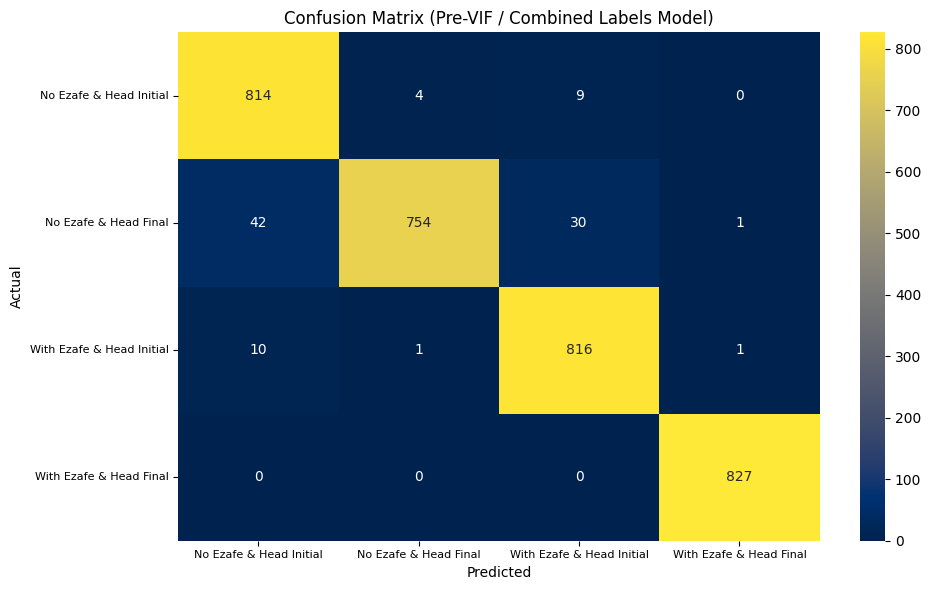


Model training and saving completed.


In [29]:
# Cell 2: Model Training & Evaluation - Pre-VIF (Combined Labels Model)
# This model uses the full feature set (dense + TF-IDF pattern) BEFORE VIF
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack # Import hstack to combine sparse and dense features
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc # Import garbage collection

# Function to preprocess data using LabelEncoder for categoricals and TF-IDF for np_deprel_pattern
# This function prepares the data *before* any VIF-based feature selection.
def preprocess_data(file_path):
    """
    Loads data, creates combined label, encodes categorical features using LabelEncoder,
    vectorizes np_deprel_pattern using TfidfVectorizer, and combines features.
    Returns the combined feature matrix, target labels, and label encoder for the target.
    """
    df = pd.read_csv(file_path)

    # Create the combined target label and encode it
    if 'combined_label' not in df.columns:
        df['combined_label'] = df['ezafe_label'].astype(str) + "_" + df['position'].astype(str)
    le_combined = LabelEncoder()
    y = le_combined.fit_transform(df['combined_label'])

    # Separate the feature to be vectorized (np_deprel_pattern)
    # Fill missing values with empty string before vectorization
    deprel_patterns = df['np_deprel_pattern'].astype(str).fillna("")

    # Drop columns not needed for X, including original targets and IDs as per thesis/previous code
    # Keep 'np_deprel_pattern' out for now, it will be vectorized
    drop_cols_for_X = ['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form',
                       'ezafe_label', 'position', 'combined_label', 'np_deprel_pattern'] # Drop original pattern string
    X_other = df.drop(columns=drop_cols_for_X, errors='ignore')

    # Encode other categorical features using LabelEncoder
    # Based on thesis tables 12-17, these are the categorical features used:
    # nominal_head_upos, nominal_head_deprel, head_number,
    # dependent_upos, dependent_deprel, source_file
    # We exclude 'np_deprel_pattern' here because it's vectorized separately.
    # We also exclude 'nominal_head_id' and 'dependent_id' as they are IDs.
    categorical_cols_other = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                              'head_number', 'source_file', 'nominal_head_upos']

    label_encoders = {}
    for col in categorical_cols_other:
         if col in X_other.columns: # Check if column exists after initial drop
             label_encoders[col] = LabelEncoder()
             # Ensure column is string type before fillna and fit_transform
             X_other[col] = X_other[col].astype(str).fillna("unknown") # Fill NaNs with a placeholder
             X_other[col] = label_encoders[col].fit_transform(X_other[col])
         else:
              print(f"Warning: Categorical column '{col}' not found in dataframe.")


    # Ensure all other features are numeric and fill any remaining missing values
    # This applies to numeric features that might have NaNs, though ideally they are handled.
    X_other = X_other.apply(pd.to_numeric, errors='coerce').fillna(-1) # Fill any remaining NaNs with -1 or mean/median


    # Vectorize the np_deprel_pattern using TfidfVectorizer as described in thesis Section 6.4
    # token_pattern=r'\S+' splits by whitespace
    # max_features=1000 is a reasonable limit to keep the feature space manageable
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\S+', max_features=1000)
    X_pattern_vectorized = tfidf_vectorizer.fit_transform(deprel_patterns)


    # Combine the dense features (X_other) with the sparse TF-IDF features
    # X_other is dense, X_pattern_vectorized is sparse. hstack can combine them into a sparse matrix.
    X_combined = hstack([X_other.values, X_pattern_vectorized])

    # Clean up memory
    del df, X_other, deprel_patterns, X_pattern_vectorized
    gc.collect()

    return X_combined, y, le_combined, tfidf_vectorizer # Return the combined feature matrix and target info


# --- Main execution for Pre-VIF Model (Combined Labels Model) ---
def main_pre_vif_model():
    print("--- Training Model: Pre-VIF (Combined Labels Model) ---")

    # Load and preprocess the data (full feature set including TF-IDF pattern)
    X_combined, y, le_combined, tfidf_vectorizer = preprocess_data("nonclausal-np_features.csv")

    # Handle class imbalance using Random Oversampler
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_combined, y)

    print(f"Resampled data shape: {X_resampled.shape}")
    print(f"Resampled target distribution:\n{pd.Series(y_resampled).value_counts().sort_index()}")

    # Split data into training and testing sets using stratified sampling
    # Stratified split ensures class distribution is similar in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )

    print(f"\nTraining set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    # Print the class distribution in the stratified test set for documentation
    print("\nClass distribution in the STRATIFIED Test Set:")
    unique, counts = np.unique(y_test, return_counts=True)
    print(dict(zip(le_combined.inverse_transform(unique), counts)))


    # Optimal hyperparameters as reported in the thesis (Section 6.6)
    # These parameters were found by tuning likely on the data *before* VIF
    best_params = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'class_weight': 'balanced'}

    # Initialize RandomForestClassifier with the optimal parameters
    rf_pre_vif = RandomForestClassifier(random_state=42, **best_params)

    print(f"\nInitializing the model with parameters: {best_params}")
    print("Fitting the model to the training data... (This might take a moment)")
    rf_pre_vif.fit(X_train, y_train)
    print("Model fitting completed.")

    # Predict on the test set
    y_pred = rf_pre_vif.predict(X_test)
    y_pred_proba = rf_pre_vif.predict_proba(X_test) # For ROC curve

    # Print classification report (using digits=4 for precision as in thesis)
    print("\nClassification Report (Pre-VIF / Combined Labels Model):")
    print(classification_report(y_test, y_pred, zero_division='warn', digits=4))

    # Define the mapping for human-readable labels based on le_combined
    encoded_class_integers = rf_pre_vif.classes_ # These are the integer labels the model predicts (0, 1, 2, 3)
    decoded_class_strings = le_combined.inverse_transform(encoded_class_integers) # Convert integers back to '0_1' strings

    human_readable_label_mapping = {
        "0_1": "No Ezafe & Head Initial",
        "0_2": "No Ezafe & Head Final",
        "1_1": "With Ezafe & Head Initial",
        "1_2": "With Ezafe & Head Final"
    }
    # Get readable labels in the order of the model's classes
    readable_labels_ordered = [human_readable_label_mapping.get(label_str, label_str) for label_str in decoded_class_strings]

    # Confusion Matrix
    # Calculate confusion matrix using the integer labels that the model predicts
    cm = confusion_matrix(y_test, y_pred, labels=encoded_class_integers)

    print("\nConfusion Matrix (Pre-VIF / Combined Labels Model - Raw Data for Plot):")
    print(cm)

    # Create the heatmap for the Confusion Matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="cividis",
                xticklabels=readable_labels_ordered, yticklabels=readable_labels_ordered)
    plt.xlabel('Predicted')
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Pre-VIF / Combined Labels Model)') # Update title
    plt.tight_layout()
    plt.show()

    # Save the trained model
    joblib.dump(rf_pre_vif, 'random_forest_model_pre_vif.pkl')
    print("\nModel training and saving completed.")

    # Return model, test data, and label encoder for subsequent plots
    return rf_pre_vif, X_test, y_test, y_pred_proba, le_combined

# Run the main function for the Pre-VIF model
rf_pre_vif_model, X_test_pre_vif, y_test_pre_vif, y_pred_proba_pre_vif, le_combined_pre_vif = main_pre_vif_model()


--- Training Model: Post-VIF ---

--- VIF Analysis ---
VIF Scores (calculated on dense features):
NOTE: TF-IDF features are NOT included in this VIF calculation.
                      Feature        VIF
2                 head_number  11.161880
7            dependent_deprel   8.806829
1         nominal_head_deprel   8.620923
6              dependent_upos   7.544842
12                   np_depth   6.440260
15  relative_position_in_sent   5.732539
13        num_dependents_head   5.128445
16                source_file   4.502565
8                    distance   3.142193
14   num_dependents_dependent   2.426916
10            num_adjs_before   2.149918
9            num_nouns_before   2.019780
4         dependent_frequency   1.742472
11             num_adjs_after   1.689946
3              head_frequency   1.390952
5      modifier_to_head_ratio   1.379394
0           nominal_head_upos   1.225634

Resampled data shape (Post-VIF Feature Set): (16544, 64)
Resampled target distribution:
0    4136


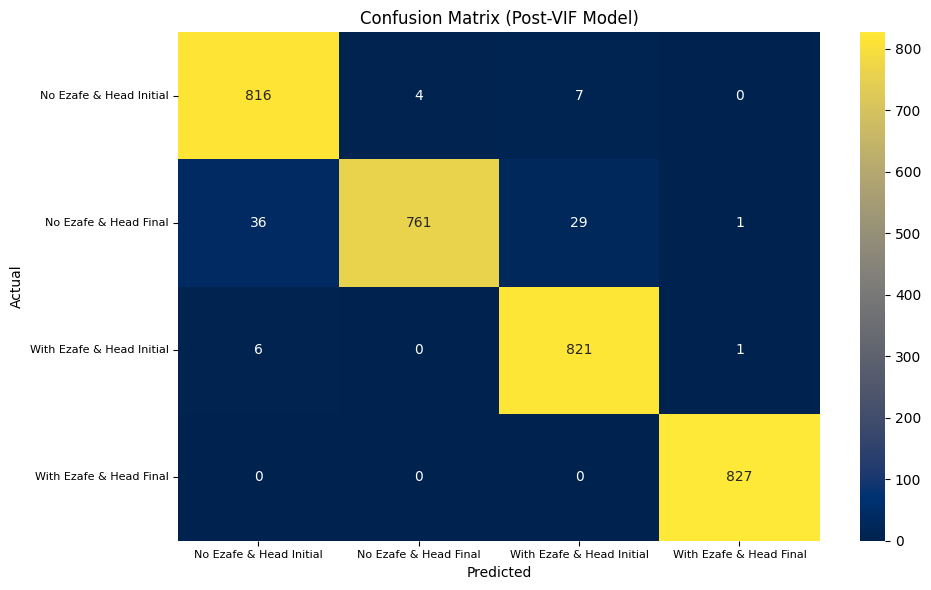


Model training and saving completed.


In [23]:
# Cell 3: Model Training & Evaluation - Post-VIF
# This model applies VIF analysis and *selectively* removes features as per thesis narrative
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from statsmodels.stats.outliers_influence import variance_inflation_factor # Keep for VIF step
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gc

# Function to calculate VIF for a dataframe of numeric features
def calculate_vif(df):
    """Calculate VIF and return dataframe sorted by VIF."""
    # Ensure all features are numeric and handle potential NaNs
    numeric_df = df.select_dtypes(include=[np.number])
    # Drop columns that cause inf VIF or are constant (often due to NaN fill)
    numeric_df = numeric_df.loc[:, (numeric_df.var() > 0)] # Remove zero-variance columns
    numeric_df = numeric_df.dropna(axis=1, how='all') # Remove columns that are all NaN/filled value

    if numeric_df.shape[1] == 0:
         print("Warning: No numeric features available for VIF calculation after filtering.")
         return pd.DataFrame(columns=["Feature", "VIF"])

    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    # Calculate VIF - add error handling for singular matrix if necessary
    try:
        # Use .values to get numpy array for statsmodels
        vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
    except np.linalg.LinAlgError as e:
        print(f"Warning: Could not compute VIF due to singular matrix. Some features may be perfectly correlated or constant. Error: {e}")
        vif_data["VIF"] = np.inf # Assign Inf VIF on error

    return vif_data.sort_values(by="VIF", ascending=False)


# Re-define preprocess_data or ensure it's available from previous cell
# (Assuming the notebook structure runs cells sequentially, it's available)
# We will use the preprocess_data function from Cell 2, but process its output specifically for VIF.


# --- Main execution for Model After VIF ---
def main_post_vif_model():
    print("\n--- Training Model: Post-VIF ---")

    # Load and preprocess the data up to the point before VIF/dropping
    X_combined, y, le_combined, tfidf_vectorizer = preprocess_data("nonclausal-np_features.csv")

    # Convert sparse X_combined to a DataFrame to easily handle columns for VIF analysis
    # This is temporary for VIF calculation on dense part and explicit dropping
    # Get feature names for the dense part
    df_temp = pd.read_csv("nonclausal-np_features.csv")
    drop_cols_for_X = ['nominal_head_id', 'nominal_head_form', 'dependent_id', 'dependent_form',
                       'ezafe_label', 'position', 'combined_label', 'np_deprel_pattern']
    X_other_temp = df_temp.drop(columns=drop_cols_for_X, errors='ignore')

    # Identify categorical columns in X_other_temp that were label encoded
    categorical_cols_other = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                              'head_number', 'source_file', 'nominal_head_upos']
    categorical_cols_present = [col for col in categorical_cols_other if col in X_other_temp.columns]

    # Encode these categoricals in the temporary dataframe for VIF calculation on numeric data
    label_encoders_temp = {}
    for col in categorical_cols_present:
         label_encoders_temp[col] = LabelEncoder()
         X_other_temp[col] = X_other_temp[col].astype(str).fillna("unknown")
         X_other_temp[col] = label_encoders_temp[col].fit_transform(X_other_temp[col])

    # Ensure all are numeric and fill any remaining missing values for VIF
    X_other_numeric_for_vif = X_other_temp.apply(pd.to_numeric, errors='coerce').fillna(-1)

    # --- VIF-Based Feature Elimination (Analysis step + Thesis-specific dropping) ---
    # Calculate VIF only on the dense, non-vectorized features (X_other_numeric_for_vif)
    print("\n--- VIF Analysis ---")
    vif_data = calculate_vif(X_other_numeric_for_vif)
    print("VIF Scores (calculated on dense features):")
    print("NOTE: TF-IDF features are NOT included in this VIF calculation.")
    print(vif_data)

    # --- Apply Thesis-Specific Feature Dropping ---
    # Thesis narrative: IDs had high VIF and were removed. relative_position_in_sent also high,
    # but its VIF dropped after removing IDs, so it was KEPT.
    # The final feature set for the "Model After VIF" in the thesis includes
    # ALL features from Tables 12-17 *except* the IDs (nominal_head_id, dependent_id)
    # and the original target columns (ezafe_label, position, combined_label).
    # The 'np_deprel_pattern' feature is included via TF-IDF.

    # Load the original DataFrame again to ensure we have the correct columns for dropping
    df_original = pd.read_csv("nonclausal-np_features.csv")

    # Define the columns to drop for the *final* feature set based on the thesis description
    # Exclude IDs and original/combined target labels. INCLUDE relative_position_in_sent.
    # np_deprel_pattern is handled by TF-IDF and will be added back.
    features_to_drop_for_post_vif_model = [
        'nominal_head_id',
        'dependent_id',
        'ezafe_label',
        'position',
        'combined_label', # This column might not exist initially, handle ignore
        'np_deprel_pattern' # Drop the string column, TF-IDF will provide vector features
    ]

    # Create the dense feature set by dropping these columns from the original dataframe
    X_dense_post_vif = df_original.drop(columns=features_to_drop_for_post_vif_model, errors='ignore')

    # Re-encode categorical columns in this reduced dense set
    # Ensure this list matches the categoricals intended to be KEPT
    categorical_cols_post_vif = ['dependent_upos', 'dependent_deprel', 'nominal_head_deprel',
                              'head_number', 'source_file', 'nominal_head_upos', 'relative_position_in_sent'] # relative_position_in_sent is numerical but was mentioned with high VIF initially

    label_encoders_post_vif = {}
    for col in categorical_cols_post_vif:
         # Check if column exists AND is of object/category dtype before encoding
         if col in X_dense_post_vif.columns and X_dense_post_vif[col].dtype == 'object':
             label_encoders_post_vif[col] = LabelEncoder()
             X_dense_post_vif[col] = X_dense_post_vif[col].astype(str).fillna("unknown")
             X_dense_post_vif[col] = label_encoders_post_vif[col].fit_transform(X_dense_post_vif[col])
         elif col in X_dense_post_vif.columns and X_dense_post_vif[col].dtype != 'object':
             # It's already numerical (like relative_position_in_sent). Just ensure no NaNs.
             X_dense_post_vif[col] = X_dense_post_vif[col].fillna(-1) # Or a suitable fill
         else:
              print(f"Warning: Column '{col}' not found in dense features after dropping IDs.")


    # Ensure all features in X_dense_post_vif are numeric and fill any remaining NaNs
    X_dense_post_vif = X_dense_post_vif.apply(pd.to_numeric, errors='coerce').fillna(-1) # Final check for NaNs


    # Combine the reduced dense features with the sparse TF-IDF features (calculated previously)
    # Use .values to get numpy array for hstack
    # Convert X_combined to csr_matrix for slicing
    X_combined_csr = X_combined.tocsr()
    X_combined_post_vif = hstack([X_dense_post_vif.values, X_combined_csr[:, X_combined_csr.shape[1] - tfidf_vectorizer.vocabulary_.__len__():]]) # Get only TF-IDF part from original combined matrix

    # Clean up temporary dataframes
    del df_temp, X_other_temp, X_other_numeric_for_vif, df_original, X_dense_post_vif
    gc.collect()


    # Handle class imbalance using Random Oversampler
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    # Use the X data AFTER VIF-based reduction
    X_resampled_post_vif, y_resampled_post_vif = ros.fit_resample(X_combined_post_vif, y)


    print(f"\nResampled data shape (Post-VIF Feature Set): {X_resampled_post_vif.shape}")
    print(f"Resampled target distribution:\n{pd.Series(y_resampled_post_vif).value_counts().sort_index()}")

    # Split data into training and testing sets using stratified sampling
    X_train_post_vif, X_test_post_vif, y_train_post_vif, y_test_post_vif = train_test_split(
        X_resampled_post_vif, y_resampled_post_vif, test_size=0.2, random_state=42, stratify=y_resampled_post_vif
    )

    print(f"\nTraining set shape (Post-VIF Feature Set): {X_train_post_vif.shape}")
    print(f"Testing set shape (Post-VIF Feature Set): {X_test_post_vif.shape}")

    # Print the class distribution in the stratified test set
    print("\nClass distribution in the STRATIFIED Test Set (Post-VIF):")
    unique, counts = np.unique(y_test_post_vif, return_counts=True)
    print(dict(zip(le_combined.inverse_transform(unique), counts)))


    # Optimal hyperparameters as reported in the thesis (Section 6.6)
    best_params = {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'class_weight': 'balanced'}

    # Initialize RandomForestClassifier with the optimal parameters
    rf_post_vif = RandomForestClassifier(random_state=42, **best_params)

    print(f"\nInitializing the model with parameters: {best_params}")
    print("Fitting the model to the training data... (This might take a moment)")
    rf_post_vif.fit(X_train_post_vif, y_train_post_vif)
    print("Model fitting completed.")

    # Predict on the test set
    y_pred_post_vif = rf_post_vif.predict(X_test_post_vif)
    y_pred_proba_post_vif = rf_post_vif.predict_proba(X_test_post_vif) # For ROC curve


    # Print classification report (using digits=4 for precision in thesis)
    print("\nClassification Report (Post-VIF Model):")
    print(classification_report(y_test_post_vif, y_pred_post_vif, zero_division='warn', digits=4))

    # Define the mapping for human-readable labels based on le_combined (from preprocess_data)
    # This should be the same label encoder as used for the Pre-VIF model's y
    encoded_class_integers = rf_post_vif.classes_
    decoded_class_strings = le_combined.inverse_transform(encoded_class_integers)

    human_readable_label_mapping = {
        "0_1": "No Ezafe & Head Initial",
        "0_2": "No Ezafe & Head Final",
        "1_1": "With Ezafe & Head Initial",
        "1_2": "With Ezafe & Head Final"
    }
    readable_labels_ordered = [human_readable_label_mapping.get(label_str, label_str) for label_str in decoded_class_strings]

    # Confusion Matrix
    cm_post_vif = confusion_matrix(y_test_post_vif, y_pred_post_vif, labels=encoded_class_integers)

    print("\nConfusion Matrix (Post-VIF Model - Raw Data for Plot):")
    print(cm_post_vif)

    # Create the heatmap for the Confusion Matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_post_vif, annot=True, fmt='d', cmap="cividis",
                xticklabels=readable_labels_ordered, yticklabels=readable_labels_ordered)
    plt.xlabel('Predicted')
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Post-VIF Model)') # Update title
    plt.tight_layout()
    plt.show()

    # Save the trained model
    joblib.dump(rf_post_vif, 'random_forest_model_post_vif.pkl')
    print("\nModel training and saving completed.")

    # Return model, test data, and label encoder for subsequent plots
    return rf_post_vif, X_test_post_vif, y_test_post_vif, y_pred_proba_post_vif, le_combined


# Run the main function for the Post-VIF model
rf_post_vif_model, X_test_post_vif, y_test_post_vif, y_pred_proba_post_vif, le_combined_post_vif = main_post_vif_model()

--- Step 3: RF Model Training and Evaluation (rf_train_evaluate.py) ---
Error: Features file 'c:\Users\rahaa\Dropbox\MPCD\the syntax project\ezafe constructions\..\data\rf_np_inputs.csv' not found. Please run rf_prepare_features.py first.


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\rahaa\\Dropbox\\MPCD\\the syntax project\\ezafe constructions\\..\\data\\rf_np_inputs.csv'

: 